In [1]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
pi = math.pi

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#functions

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [3]:
#Notes:
#Three sets of patterns. Big blobz, small blobz, and stripes.
#Big blobz (approximately of 4px by 6px), small (like starfield). 
#They are dithered with 10 to 14 intensity levels (depending
#if the are moving diagonally or cardinally).
#Only panels are included in this experiment. 
#Everything else is off. Code for pattern is saved in VD_pattern_testing

In [27]:
dataDir = '/Users/fponce/Documents/vdesert/VD_090719/data'
pattern_vdesert_data = "*.hdf5"
exp = 'VD_090719'

#ledpanels info about patterns used:
#pattern table used from vdesert params
#pattern_angles should correspond to pattern_ids 1 to 1

pattern_ids = [1,2,3,4,5,6,7,8,\
               9,10,11,12,13,14,15,16,\
               17,18,19,20,21,22,23,24]

pattern_angles = [45, 135, 90, 180, -45, 0, -90, -135,\
                  45, 135, 90, 180, -45, 0, -90, -135,\
                  -135, 45, 135, -45, 90, 180, -90, 0]

pattern_type = [0,1,2]

# type1 - 0-8 big blobs - camo 
# type2 - 9-16 small blobs - starfield
# type3 - 17-24 stripes

#vector indicating the idx of trials that need to be analyzed
all_trials_ids = [0,1,2,3,4,5,6,7,8]

#should be imported from some spreadsheet
number_unique_flies = 11
fly_id= [0,0,1,1,2,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10]
fly_id_trial = [0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1]

#for magnotether angle interpolation
number_trials = 10
trial_time = int(180*number_trials)
number_frames_per_sec = 30
print(trial_time*30)

54000


In [5]:
#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths[-1])
print(len(datapaths))

#check for keys
# for i in range(len(datapaths)):
#     f = h5py.File(datapaths[i], "r")
#     datasetNames = [n for n in f.keys()]
# print(datasetNames)

/Users/fponce/Documents/vdesert/VD_090719/data/data_2019-09-18-13-48-03.hdf5
20


In [6]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
#     params_ts = np.asarray(f['data_params_ros_tstamps'])
#     data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
#     all_params_ts.append(params_ts)
#     all_data_params.append(data_params)
    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)

In [7]:
# #quick look at  magnotether data
# for i in range(len(all_magnotether_angle)):
#     plt.figure()
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [8]:
#get ledpanels info

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
for i in range(len(datapaths)):
    idx_pat_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'send_gain_bias']
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)

#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

#get the timestamp and elapsed time of the set pattern id command
all_ros_tstamps_pat_id = []
all_ledpanels_elapsed_t_pat_id  = []
for i in range(len(all_idx_pat_command)):
    ros_tstamps_pat_id_file = []
    ledpanels_elapsed_t_pat_id_file = []
    for j in (all_idx_pat_command[i]):
        ros_tstamps_pat_id = all_ledpanels_ros_tstamps[i][j]
        ledpanels_elapsed_t_pat_id = all_ledpanels_elapsed_t[i][j]
        
        ros_tstamps_pat_id_file.append(ros_tstamps_pat_id)
        ledpanels_elapsed_t_pat_id_file.append(ledpanels_elapsed_t_pat_id)
        
    all_ros_tstamps_pat_id.append(ros_tstamps_pat_id_file)
    all_ledpanels_elapsed_t_pat_id.append(ledpanels_elapsed_t_pat_id_file) 
    
#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)
    
# print(all_ledpanels_elapsed_t_pat_id[0])
# print(all_pattern_id)
# print((all_gains))

In [9]:
#interpolation of magnotether angles

t = [0,trial_time]
reg_t = np.linspace(t[0], t[-1],(trial_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

In [10]:
#this gets the times(all_elapsed_time) when the trial changes in the virtual desert node

all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range(number_trials):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
# print(all_start_times[0])
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
# print(all_start_frames[0])
# print(all_end_frames[0])

#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
# print(all_start_times_m[0])   
# print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
# print(all_start_frames_m[0])   
# print(all_end_frames_m[0]) 

In [11]:
# experiment dependant
# map pattern_ids with angles in lab corrdinates
# get the type of pattern it was (if it was blob, starfield, stripes)

all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        p = pattern_angles[all_pattern_id[i][j]-1]
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)
#print(all_pat_angles)

all_pat_types = []
for i in range(len(all_pattern_id)):
    pat_types_file = []
    for j in range(len(all_pattern_id[i])):
        if  all_pattern_id[i][j]<=8:
            t = pattern_type[0]
        elif 9<=all_pattern_id[i][j]<=16:
            t = pattern_type[1]
        elif 17<=all_pattern_id[i][j]<=24:
            t = pattern_type[2]
        pat_types_file.append(t)
    all_pat_types.append(pat_types_file)
print(all_pat_types)

[[0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]]


In [12]:
# # #plot and save raw data
# allangles = all_magnotether_interp_angles

# for i in [0]: 
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 70), facecolor='w', edgecolor='k')
#     #fig.subplots_adjust(hspace = .2, wspace=.09, bottom=0.1)
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.96, hspace = .4, bottom=0.05)
    
#     bckclr_labels = ['lightgray','lavender','darkseagreen']
    
#     gs = gridspec.GridSpec(9, 1)
    
#     ######################################################################################################
    
#     #trial 1 + 5 sec of static pattern
#     j = 0
#     ax1 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax1.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[b]])
#     ax1.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 1
#     ax2 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax2.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax2.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax2.set_ylim([-200, 200])
#     ax2.set_xlim([reg_t[a], reg_t[b]])
#     ax2.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax2.set_yticks(np.arange(-180, 225,45))
#     ax2.yaxis.set_tick_params(labelsize=30)
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax2.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_smart_bounds(True)
#     ax2.spines['bottom'].set_smart_bounds(True)
#     ax2.spines['left'].set_linewidth(2)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 2
#     ax3 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax3.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax3.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[b]])
#     ax3.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax3.spines['left'].set_smart_bounds(True)
# #     ax3.spines['bottom'].set_smart_bounds(True)
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 3
#     ax4 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax4.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax4.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax4.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax4.set_ylim([-200, 200])
#     ax4.set_xlim([reg_t[a], reg_t[b]])
#     ax4.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax4.set_yticks(np.arange(-180, 225,45))
#     ax4.yaxis.set_tick_params(labelsize=30)
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax4.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax4.spines['left'].set_smart_bounds(True)
# #     ax4.spines['bottom'].set_smart_bounds(True)
#     ax4.spines['left'].set_linewidth(2)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 4
#     ax5 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax5.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax5.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax5.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[b]])
#     ax5.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax5.spines['left'].set_smart_bounds(True)
# #     ax5.spines['bottom'].set_smart_bounds(True)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
#     j = 5
#     ax6 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax6.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax6.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax6.set_ylim([-200, 200])
#     ax6.set_xlim([reg_t[a], reg_t[b]])
#     ax6.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax6.set_yticks(np.arange(-180, 225,45))
#     ax6.yaxis.set_tick_params(labelsize=30)
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax6.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax6.spines['left'].set_smart_bounds(True)
# #     ax6.spines['bottom'].set_smart_bounds(True)
#     ax6.spines['left'].set_linewidth(2)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(True,linewidth=2)
    
#     ######################################################################################################
    
#     # trial 2 + 5 sec of static pattern
#     j = 6
#     ax7 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax7.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax7.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax7.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax7.set_ylim([-200, 200])
#     ax7.set_xlim([reg_t[a], reg_t[b]])
#     ax7.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax7.set_yticks(np.arange(-180, 225,45))
#     ax7.yaxis.set_tick_params(labelsize=30)
#     ax7.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax7.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax7.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax7.spines['left'].set_smart_bounds(True)
# #     ax7.spines['bottom'].set_smart_bounds(True)
#     ax7.spines['left'].set_linewidth(2)
#     ax7.spines['bottom'].set_linewidth(2)
#     ax7.grid(True,linewidth=2)
#     #ax7.set_xlabel('Time (s)', fontsize=30)
    
#     ######################################################################################################
    
#     # trial 2 + 5 sec of static pattern
#     j = 7
#     ax8 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax8.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax8.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax8.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax8.set_ylim([-200, 200])
#     ax8.set_xlim([reg_t[a], reg_t[b]])
#     ax8.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax8.set_yticks(np.arange(-180, 225,45))
#     ax8.yaxis.set_tick_params(labelsize=30)
#     ax8.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax8.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax8.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax8.spines['left'].set_smart_bounds(True)
# #     ax8.spines['bottom'].set_smart_bounds(True)
#     ax8.spines['left'].set_linewidth(2)
#     ax8.spines['bottom'].set_linewidth(2)
#     ax8.grid(True,linewidth=2)
#     #ax8.set_xlabel('Time (s)', fontsize=30)  

#     ######################################################################################################
    
#     # trial 2 + 5 sec of static pattern
#     j = 8
#     ax9 = plt.subplot(gs[j, :])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax9.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax9.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax9.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax9.set_ylim([-200, 200])
#     ax9.set_xlim([reg_t[a], reg_t[b]])
#     ax9.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax9.set_yticks(np.arange(-180, 225,45))
#     ax9.yaxis.set_tick_params(labelsize=30)
#     ax9.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax9.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax9.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax9.spines['left'].set_smart_bounds(True)
# #     ax9.spines['bottom'].set_smart_bounds(True)
#     ax9.spines['left'].set_linewidth(2)
#     ax9.spines['bottom'].set_linewidth(2)
#     ax9.grid(True,linewidth=2)
#     ax9.set_xlabel('Time (s)', fontsize=30) 
#     savefigdir = '/Users/fponce/Documents/vdesert/VD_090719/'
#     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [14]:
# #plot and save raw data and pdf
# allangles = all_magnotether_interp_angles

# for i in range(len(datapaths)):
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 70), facecolor='w', edgecolor='k')
#     #fig.subplots_adjust(hspace = .2, wspace=.09, bottom=0.1)
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(fly_id[i]),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.96, hspace = .4, bottom=0.05, wspace = .2)
    
#     bckclr_labels = ['darkseagreen','lavender','whitesmoke']
#     pt_label = ['camo', 'starfield', 'stripes']
#     gs = gridspec.GridSpec(9, 8)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 1 + 5 sec of static pattern
#     j = 0
#     ax1 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax1.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[b]])
#     ax1.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.set_axisbelow(True)
#     ax1.grid(True)
    
#     ######################################################################################################
    
#     j = 0
#     ax2 = plt.subplot(gs[0,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax2.set_ylim([-200, 200])
#     ax2.set(yticks=[]) 
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_linewidth(0)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(False)
    
#     xmin, xmax = ax2.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax2.set_xticks(custom_ticks_distplot)
#     ax2.set_xticklabels(labels_distplot)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 1
#     ax3 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax3.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax3.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[b]])
#     ax3.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.set_axisbelow(True)
#     ax3.grid(True)
    
#     ######################################################################################################
    
#     j = 1
#     ax4 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax4.set_ylim([-200, 200])
#     ax4.set(yticks=[]) 
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax4.spines['left'].set_linewidth(0)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(False)
    
#     xmin, xmax = ax4.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax4.set_xticks(custom_ticks_distplot)
#     ax4.set_xticklabels(labels_distplot)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 2
#     ax5 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax5.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax5.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax5.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[b]])
#     ax5.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.set_axisbelow(True)
#     ax5.grid(True)
    
#     ######################################################################################################
    
#     j = 2
#     ax6 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax6.set_ylim([-200, 200])
#     ax6.set(yticks=[]) 
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax6.spines['left'].set_linewidth(0)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(False)
    
#     xmin, xmax = ax6.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax6.set_xticks(custom_ticks_distplot)
#     ax6.set_xticklabels(labels_distplot)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 3
#     ax7 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax7.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax7.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax7.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax7.set_ylim([-200, 200])
#     ax7.set_xlim([reg_t[a], reg_t[b]])
#     ax7.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax7.set_yticks(np.arange(-180, 225,45))
#     ax7.yaxis.set_tick_params(labelsize=30)
#     ax7.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax7.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax7.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax7.spines['left'].set_linewidth(2)
#     ax7.spines['bottom'].set_linewidth(2)
#     ax7.set_axisbelow(True)
#     ax7.grid(True)
    
#     ######################################################################################################
    
#     j = 3
#     ax8 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax8.set_ylim([-200, 200])
#     ax8.set(yticks=[]) 
#     ax8.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax8.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax8.spines['left'].set_linewidth(0)
#     ax8.spines['bottom'].set_linewidth(2)
#     ax8.grid(False)
    
#     xmin, xmax = ax8.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax8.set_xticks(custom_ticks_distplot)
#     ax8.set_xticklabels(labels_distplot)    
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 4
#     ax9 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax9.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax9.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax9.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax9.set_ylim([-200, 200])
#     ax9.set_xlim([reg_t[a], reg_t[b]])
#     ax9.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax9.set_yticks(np.arange(-180, 225,45))
#     ax9.yaxis.set_tick_params(labelsize=30)
#     ax9.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax9.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax9.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax9.spines['left'].set_linewidth(2)
#     ax9.spines['bottom'].set_linewidth(2)
#     ax9.set_axisbelow(True)
#     ax9.grid(True)
    
#     ######################################################################################################
    
#     j = 4
#     ax10 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax10.set_ylim([-200, 200])
#     ax10.set(yticks=[]) 
#     ax10.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax10.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax10.spines['left'].set_linewidth(0)
#     ax10.spines['bottom'].set_linewidth(2)
#     ax10.grid(False)
    
#     xmin, xmax = ax10.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax10.set_xticks(custom_ticks_distplot)
#     ax10.set_xticklabels(labels_distplot) 
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 5
#     ax11 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax11.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax11.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax11.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax11.set_ylim([-200, 200])
#     ax11.set_xlim([reg_t[a], reg_t[b]])
#     ax11.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax11.set_yticks(np.arange(-180, 225,45))
#     ax11.yaxis.set_tick_params(labelsize=30)
#     ax11.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax11.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax11.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax11.spines['left'].set_linewidth(2)
#     ax11.spines['bottom'].set_linewidth(2)
#     ax11.set_axisbelow(True)
#     ax11.grid(True)
    
#     ######################################################################################################
    
#     j = 5
#     ax12 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax12.set_ylim([-200, 200])
#     ax12.set(yticks=[]) 
#     ax12.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax12.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax12.spines['left'].set_linewidth(0)
#     ax12.spines['bottom'].set_linewidth(2)
#     ax12.grid(False)
    
#     xmin, xmax = ax12.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax12.set_xticks(custom_ticks_distplot)
#     ax12.set_xticklabels(labels_distplot)    
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 6
#     ax13 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax13.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax13.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax13.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax13.set_ylim([-200, 200])
#     ax13.set_xlim([reg_t[a], reg_t[b]])
#     ax13.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax13.set_yticks(np.arange(-180, 225,45))
#     ax13.yaxis.set_tick_params(labelsize=30)
#     ax13.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax13.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax13.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax13.spines['left'].set_linewidth(2)
#     ax13.spines['bottom'].set_linewidth(2)
#     ax13.set_axisbelow(True)
#     ax13.grid(True)
    
#     ######################################################################################################
    
#     j = 6
#     ax14 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax14.set_ylim([-200, 200])
#     ax14.set(yticks=[]) 
#     ax14.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax14.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax14.spines['left'].set_linewidth(0)
#     ax14.spines['bottom'].set_linewidth(2)
#     ax14.grid(False)
    
#     xmin, xmax = ax14.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax14.set_xticks(custom_ticks_distplot)
#     ax14.set_xticklabels(labels_distplot) 
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 7
#     ax15 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax15.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax15.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax15.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax15.set_ylim([-200, 200])
#     ax15.set_xlim([reg_t[a], reg_t[b]])
#     ax15.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax15.set_yticks(np.arange(-180, 225,45))
#     ax15.yaxis.set_tick_params(labelsize=30)
#     ax15.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax15.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax15.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax15.spines['left'].set_linewidth(2)
#     ax15.spines['bottom'].set_linewidth(2)
#     ax15.set_axisbelow(True)
#     ax15.grid(True)
    
#     ######################################################################################################
    
#     j = 7
#     ax16 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax16.set_ylim([-200, 200])
#     ax16.set(yticks=[]) 
#     ax16.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax16.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax16.spines['left'].set_linewidth(0)
#     ax16.spines['bottom'].set_linewidth(2)
#     ax16.grid(False)
    
#     xmin, xmax = ax16.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax16.set_xticks(custom_ticks_distplot)
#     ax16.set_xticklabels(labels_distplot) 

#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 8
#     ax17 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax17.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax17.plot((reg_t[a],reg_t[b]), (all_pat_angles[i][j], all_pat_angles[i][j]), 'green', linewidth= 3)
    
#     #plot format
#     ax17.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax17.set_ylim([-200, 200])
#     ax17.set_xlim([reg_t[a], reg_t[b]])
#     ax17.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax17.set_yticks(np.arange(-180, 225,45))
#     ax17.yaxis.set_tick_params(labelsize=30)
#     ax17.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax17.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax17.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax17.spines['left'].set_linewidth(2)
#     ax17.spines['bottom'].set_linewidth(2)
#     ax17.set_axisbelow(True)
#     ax17.grid(True)
    
#     ######################################################################################################
    
#     j = 8
#     ax18 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax18.set_ylim([-200, 200])
#     ax18.set(yticks=[]) 
#     ax18.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax18.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax18.spines['left'].set_linewidth(0)
#     ax18.spines['bottom'].set_linewidth(2)
#     ax18.grid(False)
    
#     xmin, xmax = ax18.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax18.set_xticks(custom_ticks_distplot)
#     ax18.set_xticklabels(labels_distplot)
    
    
#     savefigdir = '/Users/fponce/Documents/vdesert/VD_090719/'
#     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(fly_id[i])+'_trial_'+str(fly_id_trial[i])+'.pdf')  #bbox_inches='tight'

In [15]:
# zero the angle/normalize
allangles = all_magnotether_interp_angles
allangles_vf = copy.deepcopy(allangles)

for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles[i][j])

In [17]:
# #plot and save raw data and pdf NORMALIZED
# allangles = allangles_vf

# for i in range(len(datapaths)):#[0]: 
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 70), facecolor='w', edgecolor='k')
#     #fig.subplots_adjust(hspace = .2, wspace=.09, bottom=0.1)
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'norm data '+'Fly '+str(fly_id[i])+'_trial_'+str(fly_id_trial[i]),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.96, hspace = .4, bottom=0.05, wspace = .2)
    
#     bckclr_labels = ['darkseagreen','lavender','whitesmoke']
#     pt_label = ['camo', 'starfield', 'stripes']
#     gs = gridspec.GridSpec(9, 8)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 1 + 5 sec of static pattern
#     j = 0
#     ax1 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax1.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax1.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[b]])
#     ax1.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.set_axisbelow(True)
#     ax1.grid(True)
    
#     ######################################################################################################
    
#     j = 0
#     ax2 = plt.subplot(gs[0,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax2.set_ylim([-200, 200])
#     ax2.set(yticks=[]) 
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_linewidth(0)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(False)
    
#     xmin, xmax = ax2.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax2.set_xticks(custom_ticks_distplot)
#     ax2.set_xticklabels(labels_distplot)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 1
#     ax3 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax3.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax3.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax3.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[b]])
#     ax3.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.set_axisbelow(True)
#     ax3.grid(True)
    
#     ######################################################################################################
    
#     j = 1
#     ax4 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax4.set_ylim([-200, 200])
#     ax4.set(yticks=[]) 
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax4.spines['left'].set_linewidth(0)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(False)
    
#     xmin, xmax = ax4.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax4.set_xticks(custom_ticks_distplot)
#     ax4.set_xticklabels(labels_distplot)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 2
#     ax5 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax5.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax5.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax5.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[b]])
#     ax5.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.set_axisbelow(True)
#     ax5.grid(True)
    
#     ######################################################################################################
    
#     j = 2
#     ax6 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax6.set_ylim([-200, 200])
#     ax6.set(yticks=[]) 
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax6.spines['left'].set_linewidth(0)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(False)
    
#     xmin, xmax = ax6.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax6.set_xticks(custom_ticks_distplot)
#     ax6.set_xticklabels(labels_distplot)
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 3
#     ax7 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax7.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax7.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax7.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax7.set_ylim([-200, 200])
#     ax7.set_xlim([reg_t[a], reg_t[b]])
#     ax7.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax7.set_yticks(np.arange(-180, 225,45))
#     ax7.yaxis.set_tick_params(labelsize=30)
#     ax7.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax7.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax7.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax7.spines['left'].set_linewidth(2)
#     ax7.spines['bottom'].set_linewidth(2)
#     ax7.set_axisbelow(True)
#     ax7.grid(True)
    
#     ######################################################################################################
    
#     j = 3
#     ax8 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax8.set_ylim([-200, 200])
#     ax8.set(yticks=[]) 
#     ax8.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax8.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax8.spines['left'].set_linewidth(0)
#     ax8.spines['bottom'].set_linewidth(2)
#     ax8.grid(False)
    
#     xmin, xmax = ax8.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax8.set_xticks(custom_ticks_distplot)
#     ax8.set_xticklabels(labels_distplot)    
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 4
#     ax9 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax9.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax9.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax9.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax9.set_ylim([-200, 200])
#     ax9.set_xlim([reg_t[a], reg_t[b]])
#     ax9.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax9.set_yticks(np.arange(-180, 225,45))
#     ax9.yaxis.set_tick_params(labelsize=30)
#     ax9.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax9.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax9.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax9.spines['left'].set_linewidth(2)
#     ax9.spines['bottom'].set_linewidth(2)
#     ax9.set_axisbelow(True)
#     ax9.grid(True)
    
#     ######################################################################################################
    
#     j = 4
#     ax10 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax10.set_ylim([-200, 200])
#     ax10.set(yticks=[]) 
#     ax10.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax10.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax10.spines['left'].set_linewidth(0)
#     ax10.spines['bottom'].set_linewidth(2)
#     ax10.grid(False)
    
#     xmin, xmax = ax10.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax10.set_xticks(custom_ticks_distplot)
#     ax10.set_xticklabels(labels_distplot) 
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 5
#     ax11 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax11.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax11.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax11.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax11.set_ylim([-200, 200])
#     ax11.set_xlim([reg_t[a], reg_t[b]])
#     ax11.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax11.set_yticks(np.arange(-180, 225,45))
#     ax11.yaxis.set_tick_params(labelsize=30)
#     ax11.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax11.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax11.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax11.spines['left'].set_linewidth(2)
#     ax11.spines['bottom'].set_linewidth(2)
#     ax11.set_axisbelow(True)
#     ax11.grid(True)
    
#     ######################################################################################################
    
#     j = 5
#     ax12 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax12.set_ylim([-200, 200])
#     ax12.set(yticks=[]) 
#     ax12.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax12.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax12.spines['left'].set_linewidth(0)
#     ax12.spines['bottom'].set_linewidth(2)
#     ax12.grid(False)
    
#     xmin, xmax = ax12.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax12.set_xticks(custom_ticks_distplot)
#     ax12.set_xticklabels(labels_distplot)    
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 6
#     ax13 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax13.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax13.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax13.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax13.set_ylim([-200, 200])
#     ax13.set_xlim([reg_t[a], reg_t[b]])
#     ax13.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax13.set_yticks(np.arange(-180, 225,45))
#     ax13.yaxis.set_tick_params(labelsize=30)
#     ax13.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax13.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax13.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax13.spines['left'].set_linewidth(2)
#     ax13.spines['bottom'].set_linewidth(2)
#     ax13.set_axisbelow(True)
#     ax13.grid(True)
    
#     ######################################################################################################
    
#     j = 6
#     ax14 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax14.set_ylim([-200, 200])
#     ax14.set(yticks=[]) 
#     ax14.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax14.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax14.spines['left'].set_linewidth(0)
#     ax14.spines['bottom'].set_linewidth(2)
#     ax14.grid(False)
    
#     xmin, xmax = ax14.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax14.set_xticks(custom_ticks_distplot)
#     ax14.set_xticklabels(labels_distplot) 
    
#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 7
#     ax15 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax15.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax15.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax15.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax15.set_ylim([-200, 200])
#     ax15.set_xlim([reg_t[a], reg_t[b]])
#     ax15.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax15.set_yticks(np.arange(-180, 225,45))
#     ax15.yaxis.set_tick_params(labelsize=30)
#     ax15.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax15.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax15.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax15.spines['left'].set_linewidth(2)
#     ax15.spines['bottom'].set_linewidth(2)
#     ax15.set_axisbelow(True)
#     ax15.grid(True)
    
#     ######################################################################################################
    
#     j = 7
#     ax16 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax16.set_ylim([-200, 200])
#     ax16.set(yticks=[]) 
#     ax16.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax16.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax16.spines['left'].set_linewidth(0)
#     ax16.spines['bottom'].set_linewidth(2)
#     ax16.grid(False)
    
#     xmin, xmax = ax16.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax16.set_xticks(custom_ticks_distplot)
#     ax16.set_xticklabels(labels_distplot) 

#     ######################################################################################################
#     ######################################################################################################
#     ######################################################################################################
    
#     #trial 
#     j = 8
#     ax17 = plt.subplot(gs[j, :-1])
    
#     a = all_start_frames_m[i][j]
#     b = all_end_frames_m[i][j]
#     ang_to_plot = allangles[i][a:b] 
    
#     ax17.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     ax17.plot((reg_t[a],reg_t[b]), (0, 0), 'green', linewidth= 3)
    
#     #plot format
#     ax17.set_title('gain = '+str(all_gains[i][j])+' '+pt_label[all_pat_types[i][j]],\
#                   fontsize = 30, fontweight='bold')
#     ax17.set_ylim([-200, 200])
#     ax17.set_xlim([reg_t[a], reg_t[b]])
#     ax17.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax17.set_yticks(np.arange(-180, 225,45))
#     ax17.yaxis.set_tick_params(labelsize=30)
#     ax17.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax17.patch.set_facecolor(bckclr_labels[all_pat_types[i][j]])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax17.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
# #     ax1.spines['left'].set_smart_bounds(True)
# #     ax1.spines['bottom'].set_smart_bounds(True)
#     ax17.spines['left'].set_linewidth(2)
#     ax17.spines['bottom'].set_linewidth(2)
#     ax17.set_axisbelow(True)
#     ax17.grid(True)
    
#     ######################################################################################################
    
#     j = 8
#     ax18 = plt.subplot(gs[j,-1])
#     k = sns.distplot(ang_to_plot,bins=[-180,-135,-90,-45, 0, 45, 90, 135, 180], hist=True, norm_hist=True, \
#                      vertical=True, kde=True, kde_kws={'lw': 3})
    
#     #plot format
#     ax18.set_ylim([-200, 200])
#     ax18.set(yticks=[]) 
#     ax18.xaxis.set_tick_params(labelsize=30)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax18.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax18.spines['left'].set_linewidth(0)
#     ax18.spines['bottom'].set_linewidth(2)
#     ax18.grid(False)
    
#     xmin, xmax = ax18.get_xlim()
#     custom_ticks_distplot = np.round(np.linspace(xmin, xmax, 2),4)
#     labels_distplot = [0, custom_ticks_distplot[-1]]
#     ax18.set_xticks(custom_ticks_distplot)
#     ax18.set_xticklabels(labels_distplot)
    
    
#     savefigdir = '/Users/fponce/Documents/vdesert/VD_090719/'
#     fig.savefig(savefigdir+exp+'_normdata_'+'Fly_'+str(fly_id[i])+'_trial_'+str(fly_id_trial[i])+'.pdf')  #bbox_inches='tight'

In [18]:
#sorting trials(experiment dependant)
all_pat_t_g = []
for i in range(len(all_pattern_id)):
    pat_t_g_file = []
    for j in range(len(all_pattern_id[i])):
        if   0<=all_pattern_id[i][j]<=8 and all_gains[i][j] == 0:
            tt = 0
        elif 0<=all_pattern_id[i][j]<=8 and all_gains[i][j] == 80:
            tt = 1
        elif 0<=all_pattern_id[i][j]<=8 and all_gains[i][j] == 120:
            tt = 2            
        elif 9<=all_pattern_id[i][j]<=16 and all_gains[i][j] == 0:
            tt = 3            
        elif 9<=all_pattern_id[i][j]<=16 and all_gains[i][j] == 80:
            tt = 4 
        elif 9<=all_pattern_id[i][j]<=16 and all_gains[i][j] == 120:
            tt = 5             
        elif 16<=all_pattern_id[i][j]<=24 and all_gains[i][j] == 0:
            tt = 6              
        elif 16<=all_pattern_id[i][j]<=24 and all_gains[i][j] == 80:
            tt = 7
        elif 16<=all_pattern_id[i][j]<=24 and all_gains[i][j] == 120:
            tt = 8
        pat_t_g_file.append(tt)
    all_pat_t_g.append(pat_t_g_file)

In [19]:
print(all_pat_t_g[0])

[2, 5, 6, 0, 3, 8, 1, 4, 7]


In [20]:
all_sorted_trials = []
for i in range(len(all_pat_t_g)):
    ss = np.argsort(all_pat_t_g[i])
    all_sorted_trials.append(ss)
print(all_sorted_trials[0])

[3 6 0 4 7 1 2 8 5]


In [21]:
all_start_frames_sort = []
all_end_frames_sort = []
for i in range(len(all_pat_t_g)):
    start_frames_sort = []
    end_frames_sort = []
    for j in range(len(all_pat_t_g[i])):
        sf = np.asarray(all_start_frames_m[i])[all_sorted_trials[i][j]]
        ef = np.asarray(all_end_frames_m[i])[all_sorted_trials[i][j]]
        start_frames_sort.append(sf)
        end_frames_sort.append(ef)
    all_start_frames_sort.append(start_frames_sort)
    all_end_frames_sort.append(end_frames_sort)
print(all_start_frames_sort[0])

[16217, 32421, 14, 21618, 37823, 5414, 10815, 43224, 27020]


In [30]:
# # #plot and normalized sorted data 

# pg_labels = ['camo gain 0', 'camo gain 80', 'camo gain 120', \
#              'starfield gain 0', 'starfield gain 80', 'starfield gain 120',\
#              'stripes gain 0', 'stripes gain 80', 'stripes gain 120']

# bckclr_labels = ['darkseagreen','darkseagreen','darkseagreen',
#                  'lavender','lavender','lavender',
#                  'whitesmoke','whitesmoke','whitesmoke']

# for k in range(number_unique_flies):
#     fig, axs = plt.subplots(len(all_trials_ids),1,figsize=(15, 5*(len(all_trials_ids))))   
#     axs = axs.ravel()
#     axisorder = [0,1,2,3,4,5,6,7,8]
#     fig.subplots_adjust(top=0.96, hspace = .4, bottom=0.05, wspace = .2)

#     for j in all_trials_ids:      
#         for i in np.where(np.asarray(fly_id)==k)[0]:
            
#             axs[axisorder[j]].plot(allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
#                 color = 'k', alpha = 0.5)
        
# #                 plt.plot(reg_t[all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
# #                     allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
# #                     color = 'k', alpha = 0.5)
        
#             axs[axisorder[j]].axhline(y = 0, color = 'r')
        
#             #plt.xlim(reg_t[all_start_frames_sort[i][j]],reg_t[all_end_frames_sort[i][j]])
#             axs[axisorder[j]].set_ylim(-200, 200)
            
#             axs[axisorder[j]].set_axis_bgcolor(bckclr_labels[j])
#             sns.set_style("ticks")
            
#             sns.despine()
#             axs[axisorder[j]].tick_params(direction='out', length=8, width=2)
#             sns.despine(offset=10, trim=False);
#             axs[axisorder[j]].spines['left'].set_smart_bounds(True)
#             axs[axisorder[j]].spines['bottom'].set_smart_bounds(True)
#             axs[axisorder[j]].spines['left'].set_linewidth(2)
#             axs[axisorder[j]].spines['bottom'].set_linewidth(2)
#             axs[axisorder[j]].grid(True,linewidth=2)
#             axs[axisorder[j]].yaxis.set_tick_params(labelsize=20)
#             axs[axisorder[j]].xaxis.set_tick_params(labelsize=20)
#             axs[axisorder[j]].set_xlabel('Frames', fontsize=20)
#             axs[axisorder[j]].set_title(str(pg_labels[j]),fontsize = 15, fontweight='bold')
        
#     savefigdir = '/Users/fponce/Documents/vdesert/VD_090719/'
#     fig.savefig(savefigdir+exp+'_normdata2_'+'Fly_'+str(k)+'.pdf')  #bbox_inches='tight'

In [32]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_sort[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]])
        
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

In [62]:
# # #plot and normalized sorted data 

# pg_labels = ['camo gain 0', 'camo gain 80', 'camo gain 120', \
#              'starfield gain 0', 'starfield gain 80', 'starfield gain 120',\
#              'stripes gain 0', 'stripes gain 80', 'stripes gain 120']

# bckclr_labels = ['darkseagreen','darkseagreen','darkseagreen',
#                  'lavender','lavender','lavender',
#                  'whitesmoke','whitesmoke','whitesmoke']

# for k in range(number_unique_flies):
#     fig, axs = plt.subplots(3,3, figsize=(10, 10), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
#     axisorder = [0,1,2,3,4,5,6,7,8]
#     fig.subplots_adjust(top=0.94, hspace = .09, bottom=0.05, wspace = .2)
#     fig.suptitle('Fly_'+str(k), fontsize = 15, fontweight='bold')
#     axs = axs.ravel()
#     axisorder = [0,1,2,3,4,5,6,7,8]

#     for j in all_trials_ids:      
#         for i in np.where(np.asarray(fly_id)==k)[0]:
            
#             cms = all_circmeans_vf[i][j]
#             cvs = all_circvars_vf[i][j]
#             axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)#, s = 30, alpha = 0.9, color = 'k')
#             axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
        
#             axs[axisorder[j]].grid(False)
#             axs[axisorder[j]].set_yticks([])
#             axs[axisorder[j]].set_xticks([])
#             axs[axisorder[j]].spines['polar'].set_visible(False)
#             axs[axisorder[j]].set_rlim(0,1) 
#             axs[axisorder[j]].set_title(str(pg_labels[j]),fontsize = 15, fontweight='bold')
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[j])
#             axs[axisorder[j]].xaxis.set_tick_params(labelsize=15)
#     savefigdir = '/Users/fponce/Documents/vdesert/VD_090719/'
#     fig.savefig(savefigdir+exp+'_polarplots_'+'Fly_'+str(k)+'.pdf')  #bbox_inches='tight'

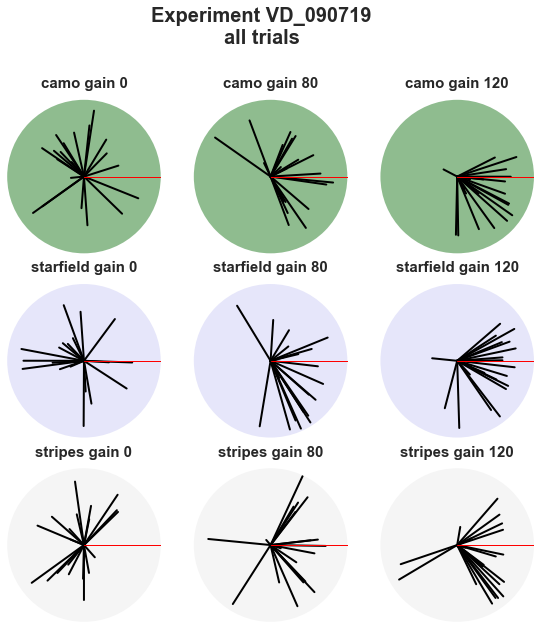

In [69]:
# circular means plot

pg_labels = ['camo gain 0', 'camo gain 80', 'camo gain 120', \
             'starfield gain 0', 'starfield gain 80', 'starfield gain 120',\
             'stripes gain 0', 'stripes gain 80', 'stripes gain 120']

bckclr_labels = ['darkseagreen','darkseagreen','darkseagreen',
                 'lavender','lavender','lavender',
                 'whitesmoke','whitesmoke','whitesmoke']

sns.set_style('dark')
fig, axs = plt.subplots(3,3, figsize=(10, 10), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .2, wspace=.01,top=0.85)
fig.suptitle('Experiment '+exp+'\n'+'all trials',fontsize = 20, fontweight='bold')

axs = axs.ravel()
axisorder = [0,1,2,3,4,5,6,7,8]

for j in axisorder:
    for i in range(len(all_circmeans_vf)):
        cms = all_circmeans_vf[i][j]
        cvs = all_circvars_vf[i][j]
        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)#, s = 30, alpha = 0.9, color = 'k')
        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
        #axs[axisorder[j]].arrow(0,0,cms, cvs, color = 'k', alpha = 1, width = 0.000005,edgecolor = 'black', facecolor = 'k', lw = 2)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(False)
        axs[axisorder[j]].set_rlim(0,1) 
        axs[axisorder[j]].set_title(str(pg_labels[j]),fontsize = 15, fontweight='bold')
        axs[axisorder[j]].patch.set_facecolor(bckclr_labels[j])
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15)

# axs[7].grid(False)
# axs[7].set_yticks([])
# axs[7].set_xticks([])
# axs[7].spines['polar'].set_visible(False)
# axs[7].set_rlim(0,1) 
# axs[7].patch.set_facecolor('white')
# axs[7].xaxis.set_tick_params(labelsize=15)

    savefigdir = '/Users/fponce/Documents/vdesert/VD_090719/'
    fig.savefig(savefigdir+exp+'_polarplots_'+'.pdf')  #bbox_inches='tight'


In [ ]:
# # #normalized figs
# sns.set_style("ticks")
# pg_labels = ['stripes gain 0', 'stripes gain 80', 'stripes gain 120', \
#              'starfield gain 0', 'starfield gain 80', 'starfield gain 120',\
#              'cameo gain 0', 'cameo gain 80', 'cameo gain 120']
# for j in all_trials_ids:    
#     fig, ax1 = plt.subplots(1,1,figsize=(15, 5))    
#     for i in range(len(allangles_vf)):
#         plt.plot(
#                 allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
#                 color = 'k', alpha = 0.5)
        
# #         plt.plot(reg_t[all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
# #                 allangles_vf[i][all_start_frames_sort[i][j]:all_end_frames_sort[i][j]],\
# #                 color = 'k', alpha = 0.5)
        
#         plt.axhline(y = 0, color = 'r')
        
#         #plt.xlim(reg_t[all_start_frames_sort[i][j]],reg_t[all_end_frames_sort[i][j]])
#         plt.ylim(-200, 200)
        
#         ax1.patch.set_facecolor('lavender')
#         sns.set_style("ticks")
#         sns.despine()
#         ax1.tick_params(direction='out', length=8, width=2)
#         sns.despine(offset=10, trim=False);
#         ax1.spines['left'].set_smart_bounds(True)
#         ax1.spines['bottom'].set_smart_bounds(True)
#         ax1.spines['left'].set_linewidth(2)
#         ax1.spines['bottom'].set_linewidth(2)
#         ax1.grid(True,linewidth=2)
#         ax1.yaxis.set_tick_params(labelsize=20)
#         ax1.xaxis.set_tick_params(labelsize=20)
#         ax1.set_xlabel('Frames', fontsize=20)
#         ax1.set_title(str(pg_labels[j]),fontsize = 20, fontweight='bold')